# Debugging Infomap

The aim of this notebook is to determine if there is an unwanted reason for infomap sorting all 1000-node networks into a single, large community.

In [1]:
import yaml
import networkx as nx
import numpy as np
from infomap import Infomap

In [5]:
def num_communities(graph_name, algo, n_nodes):
    print(graph_name)
    file_name = '../LFR_Graph_Data/{0}_Node/Community_Data/'.format(n_nodes) + algo + '/Runs/' + graph_name + '_runs.npy'
    runs = np.load(file_name)
    comms_freq = {}
    for run_num in range(runs.shape[0]):
        run = runs[run_num, :]
        num_comms = np.max(run)
        if num_comms in comms_freq.keys():
            comms_freq[num_comms] += 1
        else:
            comms_freq[num_comms] = 1
    for i,j in comms_freq.items():
        print('{0} Communities are found {1} times'.format(i,j))

There is a single 200-node graph which also gets sorted into 1 community only.

In [6]:
graph = 'graph_02_mu_0_4'
num_communities(graph, 'Infomap', 200)

graph_02_mu_0_4
1 Communities are found 1000 times


We can verify that running Infomap on this graph generates only one community:

In [9]:
with open('../LFR_Graph_Data/200_Node/mu_0_4/graph_02/graph_02_mu_0_4.yml') as f:
    graph_info = yaml.load(f, Loader=yaml.Loader)
G = graph_info['G']
im = Infomap()
im.add_nodes(range(200))
im.add_links(list(G.edges()))
im.run('--silent')

In [11]:
partition = im.get_modules()
print('Number of communities is {0}'.format(np.max(list(partition.values()))))

Number of communities is 1


However there is a flag we can use to ensure Infomap doesn't accept a 1-community solution.

In [12]:
im = Infomap('--prefer-modular-solution')
im.add_nodes(range(200))
im.add_links(list(G.edges()))
im.run('--silent --prefer-modular-solution')

In [13]:
partition = im.get_modules()
print('Number of communities is {0}'.format(np.max(list(partition.values()))))

Number of communities is 9


Now we try this same process on one of the 1000-node graphs which collapses to a single community solution. First check that all the 1000 solutions found before were 1 community.

In [14]:
graph = 'graph_02_mu_0_4'
num_communities(graph, 'Infomap', 1000)

graph_02_mu_0_4
1 Communities are found 1000 times


Now verify that running Infomap generates 1 community only.

In [15]:
with open('../LFR_Graph_Data/1000_Node/mu_0_4/graph_02/graph_02_mu_0_4.yml') as f:
    graph_info = yaml.load(f, Loader=yaml.Loader)
G = graph_info['G']
im = Infomap()
im.add_nodes(range(200))
im.add_links(list(G.edges()))
im.run('--silent')

In [16]:
partition = im.get_modules()
print('Number of communities is {0}'.format(np.max(list(partition.values()))))

Number of communities is 1


Finally, add the flag to prevent the solution collapsing to 1 community.

In [17]:
im = Infomap('--prefer-modular-solution')
im.add_nodes(range(200))
im.add_links(list(G.edges()))
im.run('--silent --prefer-modular-solution')

In [18]:
partition = im.get_modules()
print('Number of communities is {0}'.format(np.max(list(partition.values()))))

Number of communities is 1


This solution has not worked for the 1000-node graph. To confirm, the ground truth communities generated by the LFR benchmark DO NOT consist of 1 large community only.

In the LFR paper, they show that Infomap has a very high NMI for LFR-benchmark graphs with mixing parameter 0.4, so this is inconsistent with what I am finding here. To confirm this disparity, let's generate a new 1000-node graph using the exact parameters used in the LFR paper.

I'm not sure what tau1 and tau2 were meant to be, but I've used the average degree and max degree quoted in their paper.

In [66]:
G = nx.generators.community.LFR_benchmark_graph(1000, 3, 2, 0.4, average_degree=20, max_degree=50)

In [67]:
im = Infomap('--prefer-modular-solution')
im.add_nodes(range(200))
im.add_links(list(G.edges()))
im.run('--silent --prefer-modular-solution')

In [68]:
partition = im.get_modules()
print('Number of communities is {0}'.format(np.max(list(partition.values()))))

Number of communities is 36


So this has now worked - we don't have only 1 community. Let's try without the flag as well.

In [69]:
im = Infomap()
im.add_nodes(range(200))
im.add_links(list(G.edges()))
im.run('--silent')

In [70]:
partition = im.get_modules()
print('Number of communities is {0}'.format(np.max(list(partition.values()))))

Number of communities is 32


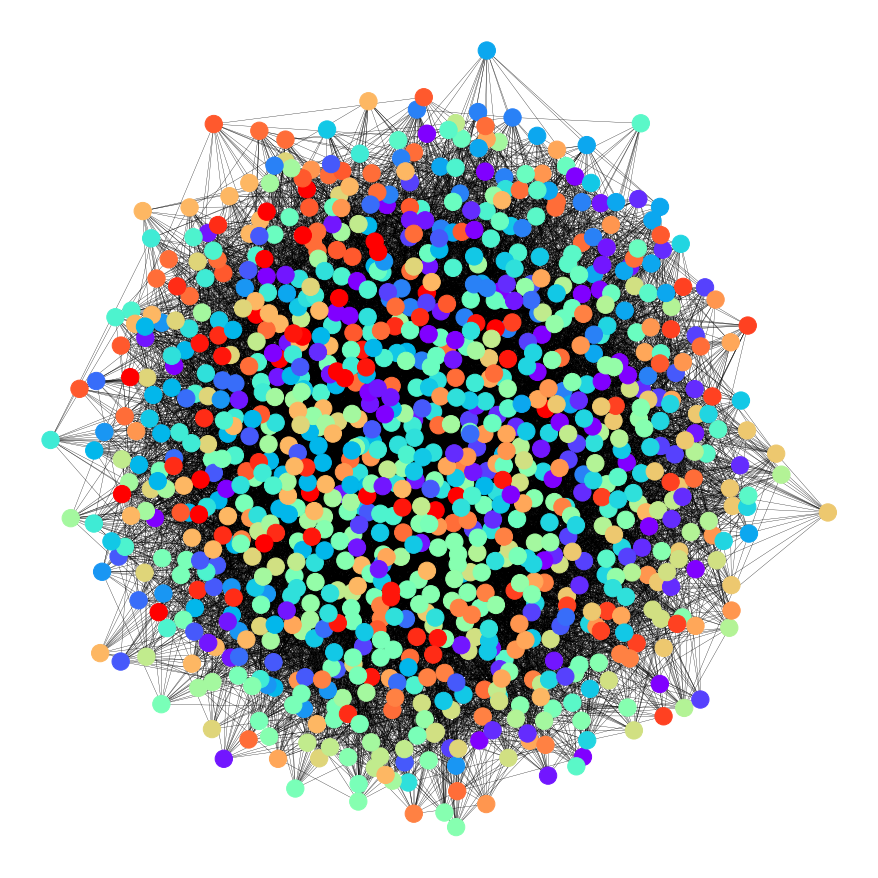

In [71]:
import matplotlib.pyplot as plt
pos = nx.spring_layout(G, k=0.5)
communities = []
ground_truth_communities = []
for node in G.nodes:
    if G.nodes[node]['community'] not in communities:
        communities.append(G.nodes[node]['community'])
    ground_truth = communities.index(G.nodes[node]['community'])
    G.nodes[node]['community'] = ground_truth
    ground_truth_communities.append(ground_truth)
plt.figure(2, figsize=(12,12))
nx.draw(G, pos, with_labels=False, node_color=ground_truth_communities, width=0.3, cmap=plt.cm.get_cmap('rainbow'))

In [41]:
from sklearn.metrics import normalized_mutual_info_score

In [72]:
partition_list = [comm for nod, comm in partition.items()]

In [73]:
nmi = normalized_mutual_info_score(ground_truth_communities, partition_list, average_method='arithmetic' )
print("NMI score=%.3f" % nmi)

NMI score=0.949


So Infomap appears to WORK for LFR graphs with different parameters to the ones we have been using.